In [7]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
import pdb

from sklearn.linear_model.coordinate_descent import _alpha_grid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV

from pyuoi.linear_model.cassolasso import PycLassoCV
from pyuoi.linear_model.casso_en import PycElasticNetCV, UoI_ElasticNet

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from results_manager import init_results_container, calc_path_result
import pandas as pd
import pycasso

In [8]:
# Initialize R interface 
from rpy2.robjects.packages import importr
ncvreg = importr('ncvreg')

# Auto-convert numpy to R as needed
from rpy2.robjects import numpy2ri
numpy2ri.activate()

# Call R
import rpy2.robjects as robjects

In [9]:
# Generate data that can be exported to R:

n_features = 100
n_samples = 400

# 3 different covariance structures, 2 different signal to noise ratios, 2 different betawidths
cov_params = [
    {'correlation' : 0, 'block_size' : 100, 'L' : 1, 't' : 0},
    {'correlation' : 0.33, 'block_size' : 10, 'L' : 1, 't' : 0},
    {'correlation' : 0, 'block_size' : 100, 'L' : 5, 't' : 1},    
]

kappa = [100, 5]
betawidth = [np.inf, 0]

sparsity = np.linspace(0.1, 1, 10)

iter_params = {'cov_params': cov_params, 'sparsity': sparsity, 'kappa': kappa, 'betawidth': betawidth}
const_params = {'n_features': n_features, 'n_samples': 400}

param_comb = list(itertools.product(*[iter_params[key] for key in iter_params.keys()]))

final_params = []
for i in range(len(param_comb)):
    arg_dict = const_params.copy()
    for j, key in enumerate(iter_params.keys()):
        arg_dict[key] = param_comb[i][j]
    arg_dict['index'] = i
    final_params.append(arg_dict)

final_params_rep = final_params * 5

In [11]:
# Execute the 4 algorithms of interest - benchmark against lasso
fields = ['FNR', 'FPR', 'sa', 'ee', 'median_ee']
selection_methods = ['lasso', 'pyc_mcp', 'r_mcp', 'pyc_scad', 'r_scad']
results = init_results_container(selection_methods, fields, len(final_params_rep), n_features)

lasso_times = np.zeros(len(final_params_rep))

pyc_mcp_times = np.zeros(len(final_params_rep))
r_mcp_times = np.zeros(len(final_params_rep))

pyc_scad_times = np.zeros(len(final_params_rep))
r_scad_times = np.zeros(len(final_params_rep))

for i, p in enumerate(final_params_rep):
    
    # Store the parameters
    for key, item in p.items():
        results[key] = item
    
    sigma = gen_covariance(p['n_features'], **p['cov_params'])
    beta = gen_beta2(p['n_features'], p['cov_params']['block_size'], sparsity = p['sparsity'], betawidth = p['betawidth'])
    X, X_test, y, y_test, ss = gen_data(p['n_samples'], p['n_features'], kappa = p['kappa'], 
                                        covariance = sigma, beta = beta)
    
    X = StandardScaler().fit_transform(X)
    y -= np.mean(y)
 

    exp_results = []
    
    t0 = time.time()
    lasso = pycasso.Solver(X, y, family = 'gaussian',
                          useintercept = False,
                          penalty = 'l1')
    lasso.train()
    lasso_times[i] = time.time() - t0
    exp_results.append({})
    exp_results[0]['coefs'] = lasso.result['beta']
    
    t0 = time.time()
    mcp1 = pycasso.Solver(X, y, family = 'gaussian',
                          useintercept = False, 
                          gamma = 3,
                          penalty = 'mcp')
    mcp1.train()
    pyc_mcp_times[i] = time.time() - t0
    exp_results.append({})
    exp_results[1]['coefs'] = mcp1.result['beta']

    mcp_alphas = mcp1.lambdas
        
    t0 = time.time()
    mcp2 = ncvreg.ncvreg(X, y, family = 'gaussian', 
                         penalty = 'MCP', gamma = 3,
                         **{'lambda' : mcp_alphas})
    # Discard the intercept and transpose
    mcp2_coefs = np.array(mcp2[0])[1:].T
    r_mcp_times[i] = time.time() - t0    

    exp_results.append({})
    exp_results[2]['coefs'] = mcp2_coefs
            
    t0 = time.time()
    scad1 = pycasso.Solver(X, y, family = 'gaussian',
                          useintercept = False, 
                          gamma = 3.7,
                          penalty = 'scad')
    scad1.train()
    pyc_scad_times[i] = time.time() - t0
    exp_results.append({})
    exp_results[3]['coefs'] = scad1.result['beta']
    
    scad_alphas = scad1.lambdas
    
    t0 = time.time()
    scad2 = ncvreg.ncvreg(X, y, family = 'gaussian', penalty = 'SCAD', gamma = 3.7,
                          **{'lambda' : scad_alphas})
    # Discard the intercept and transpose
    scad2_coefs = np.array(scad2[0])[1:].T
    r_scad_times[i] = time.time() - t0    

    exp_results.append({})
    exp_results[4]['coefs'] = scad2_coefs.T

    # perform calculations
    for j, selection_method in enumerate(selection_methods):
        for field in fields:
            results[selection_method][field][i] = calc_path_result(X, X_test, y, y_test, 
                                                                   beta.ravel(), field, 
                                                                   exp_results[j])
        
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


In [ ]:
plt.plot()

In [27]:
results['pyc_mcp']['sa'].shape

(600,)

In [12]:
final_params = pd.DataFrame(final_params)
from misc import calc_avg_cov

TypeError: Dimensions of C (10, 12) are incompatible with X (3) and/or Y (10); see help(pcolormesh)

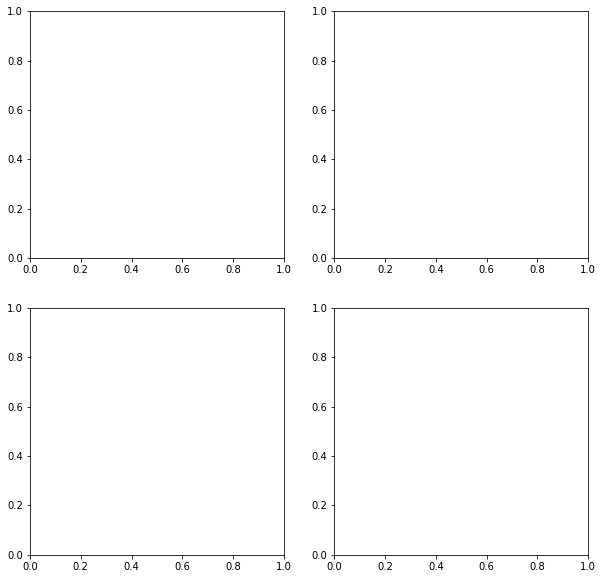

In [20]:
# Fix SNR, betawidth, and plot selection accuracy and estimation error
d = final_params.loc[(final_params['kappa'] == 5) & (final_params['betawidth'] == np.inf)]

# Plot colormaps of sparsity vs. average corrrelation
sparsity = np.unique(d['sparsity'].values)

# track differences between the two solvers
lasso_sa_diff = np.zeros((10, 12))
en_sa_diff = np.zeros((10, 12))

lasso_ee_diff = np.zeros((10, 12))
en_ee_diff = np.zeros((10, 12))

for i, s in enumerate(sparsity):
    dd = d.loc[d['sparsity'] == s]
    
    avg_cov = np.zeros(dd.shape[0])
    
    # calculate average covariance
    for j in range(dd.shape[0]):
        avg_cov[j] = calc_avg_cov(n_features, **dd.iloc[j]['cov_params'])
    
        lasso_sa_diff[i, j] = results['pyc_mcp']['sa'][dd.iloc[j]['index']] - \
                              results['r_mcp']['sa'][dd.iloc[j]['index']]
    
        en_sa_diff[i, j] =  results['pyc_scad']['sa'][dd.iloc[j]['index']] - \
                            results['r_scad']['sa'][dd.iloc[j]['index']]

        lasso_ee_diff[i, j] = (results['pyc_mcp']['ee'][dd.iloc[j]['index']] - \
                              results['r_mcp']['ee'][dd.iloc[j]['index']])\
                              /results['pyc_mcp']['ee'][dd.iloc[j]['index']]
    
        en_ee_diff[i, j] =  (results['pyc_scad']['ee'][dd.iloc[j]['index']] - \
                            results['r_scad']['ee'][dd.iloc[j]['index']])\
                            /results['pyc_scad']['ee'][dd.iloc[j]['index']]


fig, ax = plt.subplots(2, 2, figsize = (10, 10))

a1 = ax[0, 0].pcolormesh(avg_cov, sparsity, lasso_sa_diff)
ax[0,0].set_title('MCP Selection Accuracy Diff', fontsize = 14)
ax[0, 0].set_ylabel('Increasing Density', fontsize = 14)
fig.colorbar(a1, ax = ax[0, 0])

a2 = ax[0, 1].pcolormesh(lasso_ee_diff)
ax[0, 1].set_title('MCP Fractional Estimation Error Diff', fontsize = 14)

fig.colorbar(a2, ax = ax[0, 1])

a3 = ax[1, 0].pcolormesh(en_sa_diff)
ax[1, 0].set_title('SCAD Selection ACcuracy Diff', fontsize = 14)
ax[1, 0].set_xlabel('Increasing average covariance')
fig.colorbar(a3, ax = ax[1, 0])

a4 = ax[1, 1].pcolormesh(en_ee_diff)
ax[1, 1].set_title('SCAD Fractional Estimation Error Diff')
fig.colorbar(a4, ax = ax[1, 1])